# Test the hologram performances with QSO 3C273
==================================================================================================

- author : Jérémy Neveu
- date   : June 5th 2017


In [1]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

print theNotebook
from IPython.display import Image, display
import sys
sys.path.append("../../common_tools/")
from common_notebook import *

init_notebook()

FullAnalysis
ccdproc version 1.2.0
bottleneck version 1.2.0
/Users/jneveu/Documents/LSST/Calibration/CTIOAnaJun2017/ana_05jun17/QSO_3C273


### Input directory

In [3]:
#inputdir="../OverScanRemove/trim_images"
inputdir="../../data/CTIODataJune2017_reducedRed/data_05jun17/"
MIN_IMGNUMBER=5
MAX_IMGNUMBER=8
date="20170605"
object_name='QS0_3C273'
tag = "reduc"
SelectTagRe='^%s_%s_([0-9]+).fits$' % (tag,date) # regular expression to select the file
SearchTagRe='^%s_%s_[0-9]+.fits$' % (tag,date)
NBIMGPERROW=2

### Output directories

In [4]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images
ensure_dir(dir_top_images) # create that directory

outputdir="./cut_fitsimages"
ensure_dir(outputdir)

## Location of the spectra
----------------------------------

In [5]:
dirlist_all = [inputdir]
sorted_numbers,sorted_files = MakeFileList(dirlist_all,MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe) 

all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

print 'Number of images:',len(all_images)

Number of images: 4


### Show images

Processing image 0...
Processing image 1...
Processing image 2...
Processing image 3...


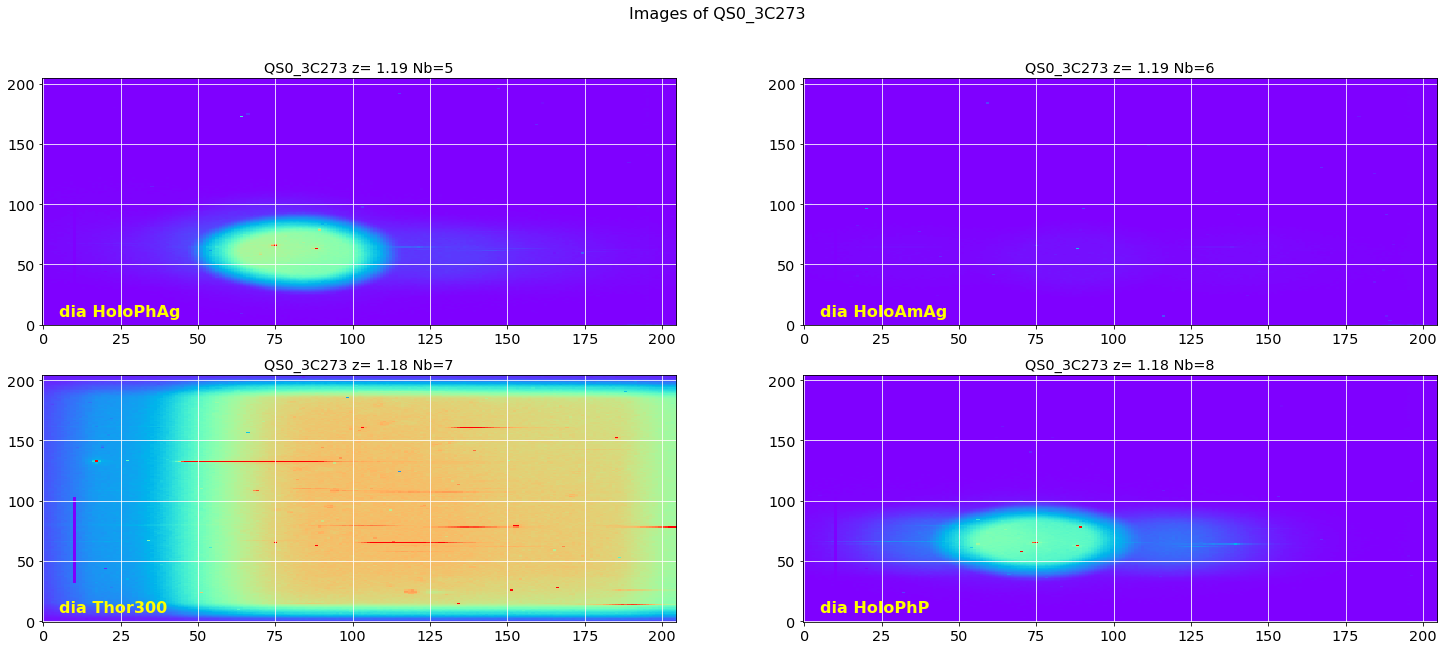

In [7]:
ShowImages(all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=10000,downsampling=10,verbose=True)

figfilename=os.path.join(dir_top_images,'input_images.pdf')
plt.savefig(figfilename)   

### Show histograms

Processing image 0...
Processing image 1...
Processing image 2...
Processing image 3...


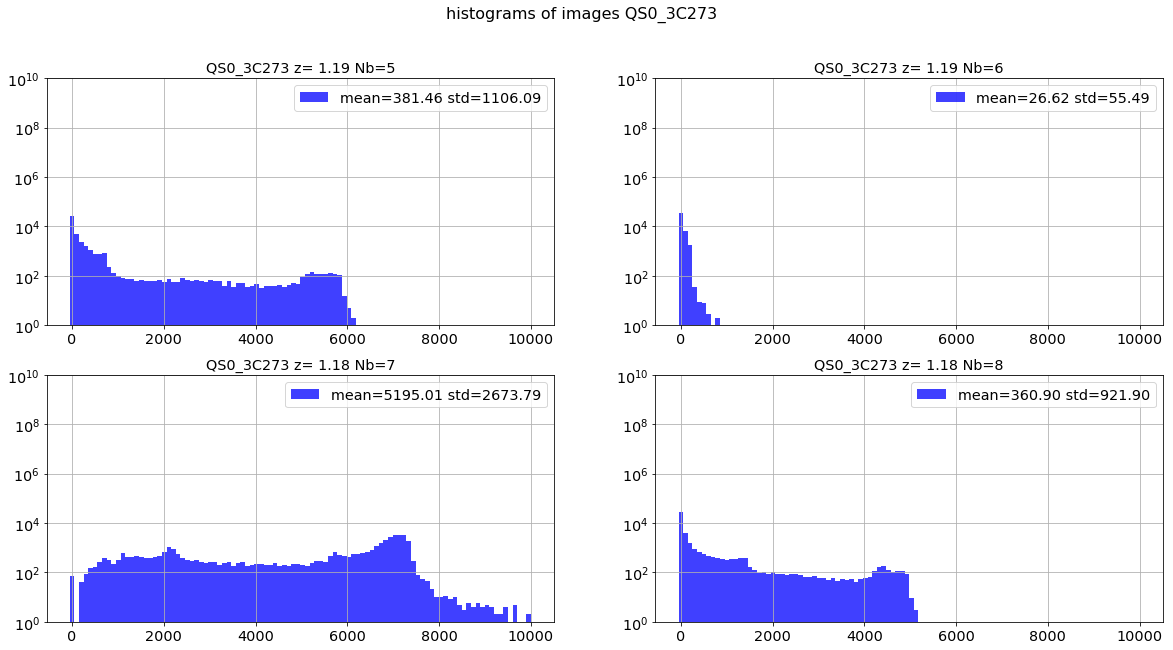

In [8]:
ShowHistograms(all_images,all_titles,all_filt,object_name,
               NBIMGPERROW=2,bins=100,range=(-50,10000),downsampling=10,verbose=True)

### Cut the images

To extract the spectra to analyze

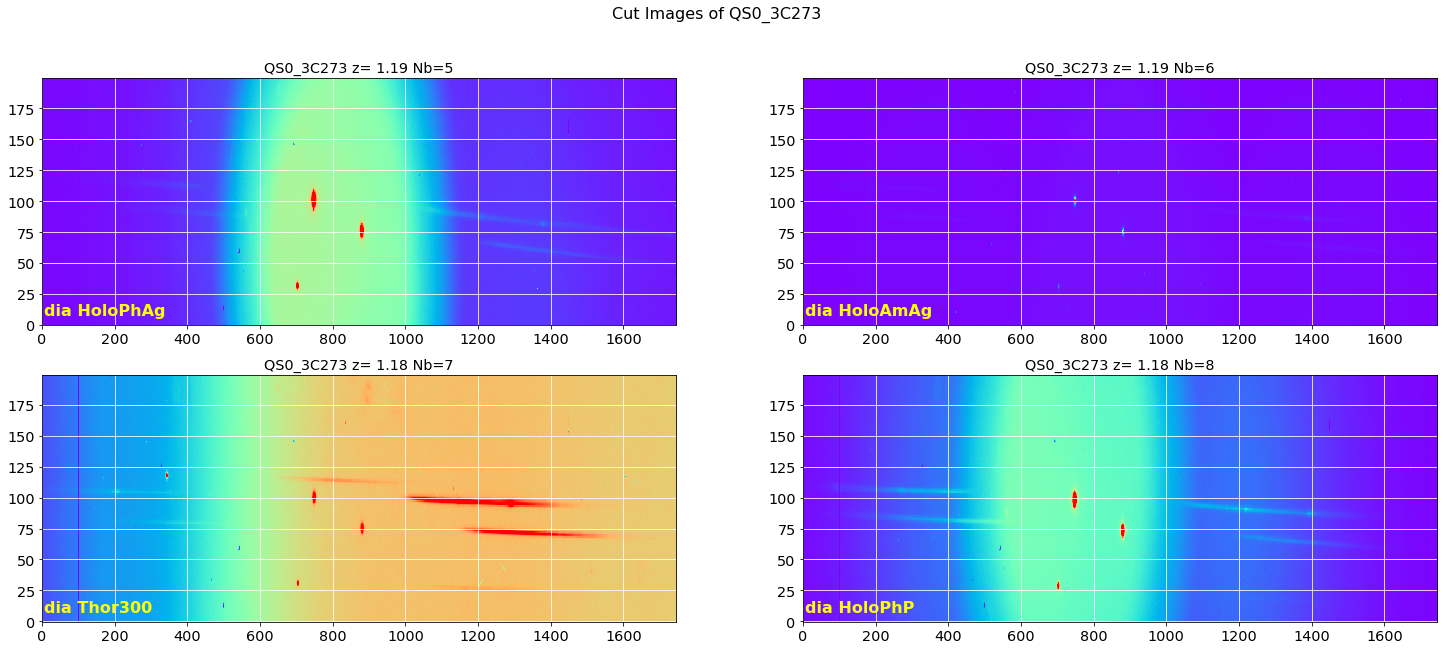

In [9]:
x_guess = [745]*len(all_images)
y_guess = [653]*len(all_images)
DeltaY=[100]*len(all_images)
DeltaX=[1000]*len(all_images)

images_cut=ShowCenterImages(x_guess,y_guess,DeltaX,DeltaY,all_images,all_titles,all_filt,object_name,
                            NBIMGPERROW=2,vmin=0,vmax=10000)
figfilename=os.path.join(dir_top_images,'cut_images.pdf')
plt.savefig(figfilename)   

### Save cut images

In [10]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[-1]
    print short_infilename
    short_partfilename=re.findall('^%s_(.*)' % tag,short_infilename)
    short_outfilename='cutimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)
    
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)

reduc_20170605_005.fits
reduc_20170605_006.fits
reduc_20170605_007.fits
reduc_20170605_008.fits


In [11]:
!ls -l cut_fitsimages/*

-rw-r--r--  1 jneveu  staff  2805120  8 aoû 14:45 cut_fitsimages/cutimg_20170605_005.fits
-rw-r--r--  1 jneveu  staff  2805120  8 aoû 14:45 cut_fitsimages/cutimg_20170605_006.fits
-rw-r--r--  1 jneveu  staff  2805120  8 aoû 14:45 cut_fitsimages/cutimg_20170605_007.fits
-rw-r--r--  1 jneveu  staff  2805120  8 aoû 14:45 cut_fitsimages/cutimg_20170605_008.fits


# Find the optimal rotation of the spectra
============================

In [12]:
inputdir="./cut_fitsimages"
SelectTagRe='^cutimg_%s_([0-9]+).fits$' % date # regular expression to select the file
SearchTagRe='^cutimg_%s_[0-9]+.fits$' % date

outputdir="./rotated_fitsimages"
ensure_dir(outputdir)

In [13]:
sorted_numbers,sorted_files = MakeFileList([inputdir],MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe) 

all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

print 'Number of images:',len(all_images)

Number of images: 4


## Find rotation by Hessian analysis

La méthode s'inspire des techniques de détection de filmanents dans le milieu interstellaire.
Elle est décrite dans https://arxiv.org/pdf/1409.6728.pdf section 4.1.
Documentation sur le calcul du Hessien : http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hessian_matrix

### Test rotation optimal settings

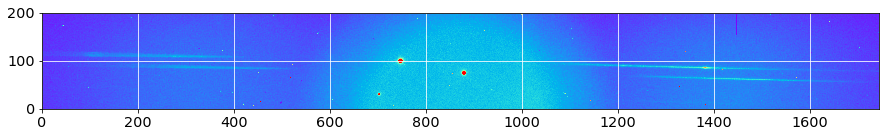

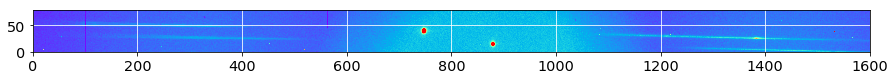

In [14]:
sel=1
image_sel=np.copy(all_images[sel])
y0=DeltaY[sel]
x0=x_guess[sel]

width_cut = 40
right_edge = 1600

plt.imshow(image_sel,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()

region=np.copy(image_sel[y0-width_cut:y0+width_cut,0:right_edge])
data=np.copy(region)
plt.imshow(data,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()

In [45]:
# le paramètre sigma permet de lisser le hessien
Hxx, Hxy, Hyy = hessian_matrix(data, sigma=3, order = 'xy')
lambda_plus = 0.5*( (Hxx+Hyy) + np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
lambda_minus = 0.5*( (Hxx+Hyy) - np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
theta = 0.5*np.arctan2(2*Hxy,Hyy-Hxx)*180/np.pi

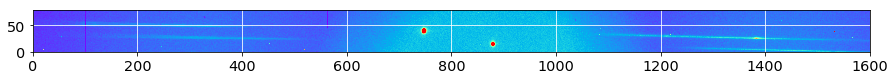

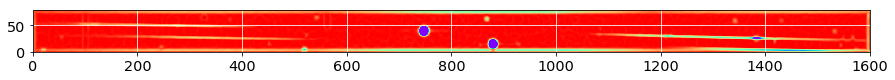

In [46]:
plt.imshow(data,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()
plt.imshow(lambda_minus,origin='lower',cmap='rainbow',vmin=-10,vmax=0)
plt.grid(color='white', ls='solid')
plt.show()

Number of remaining pixels : 3725


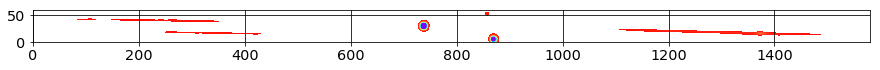

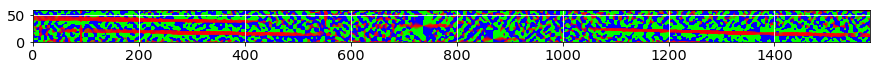

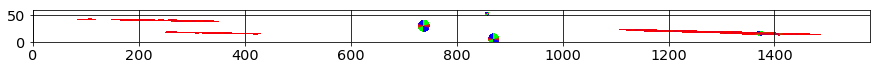

In [47]:
lambda_threshold = -2
margin_cut = 10

lambda_minus = lambda_minus[margin_cut:-margin_cut,margin_cut:-margin_cut]
lambda_plus = lambda_plus[margin_cut:-margin_cut,margin_cut:-margin_cut]
theta = theta[margin_cut:-margin_cut,margin_cut:-margin_cut]

mask = np.where(lambda_minus>lambda_threshold)
lambda_mask = np.copy(lambda_minus)
lambda_mask[mask]=np.nan

theta_mask = np.copy(theta)
theta_mask[mask]=np.nan

print 'Number of remaining pixels :',len(lambda_mask[~np.isnan(lambda_mask)])

plt.imshow(lambda_mask,origin='lower',cmap='rainbow',vmin=-100,vmax=0)
plt.grid(color='black', ls='solid')
plt.show()

plt.imshow(theta,origin='lower',cmap=cm.brg,vmin=-30,vmax=30)
plt.grid(color='white', ls='solid')
plt.show()

plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-30,vmax=30)
plt.grid(color='black', ls='solid')
plt.show()

Number of remaining pixels : 2979


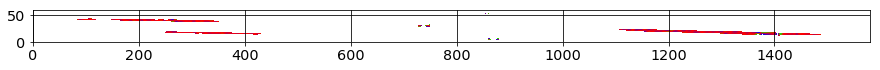

In [48]:
deg_threshold = 10

mask2 = np.where(np.abs(theta)>deg_threshold)
theta_mask[mask2] = np.nan
print 'Number of remaining pixels :',len(theta_mask[~np.isnan(theta_mask)])
plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-deg_threshold,vmax=deg_threshold)
plt.grid(color='black', ls='solid')
plt.show()

Angle median : -1.17217317276


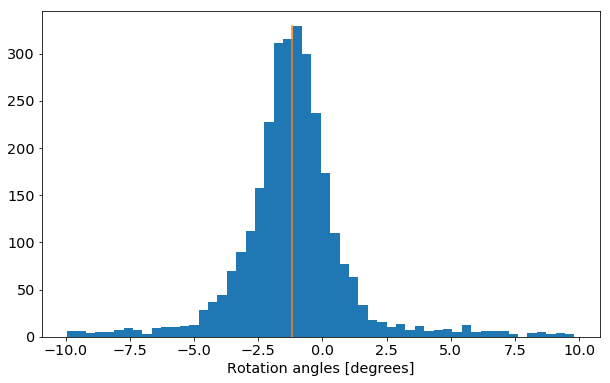

In [49]:
theta_hist = []
theta_hist = theta_mask[~np.isnan(theta_mask)].flatten()
theta_median = np.median(theta_hist)
print 'Angle median :',theta_median
fig = plt.figure(figsize=(10,6))
n,bins, patches = plt.hist(theta_hist,bins=int(np.sqrt(len(theta_hist))))
plt.plot([theta_median,theta_median],[0,np.max(n)])
plt.xlabel("Rotation angles [degrees]")
plt.show()

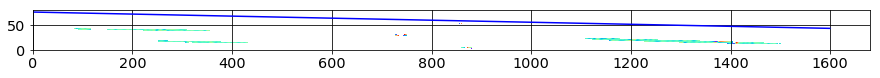

In [50]:
xindex=np.arange(data.shape[1])
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = y0 - width_cut + (x_new-x0)*np.tan(theta_median*np.pi/180.)
plt.imshow(theta_mask,origin='lower',cmap='rainbow',vmin=-deg_threshold,vmax=deg_threshold)
plt.plot(x_new,y_new,'b-')
plt.grid(color='black', ls='solid')
plt.show()

On peut aussi essayer de fitter le spectre qui a été détecté par la méthode ci-dessus.

Rotation angle from fit : -0.804669287537


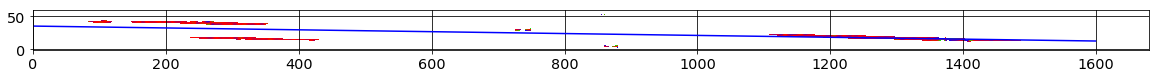

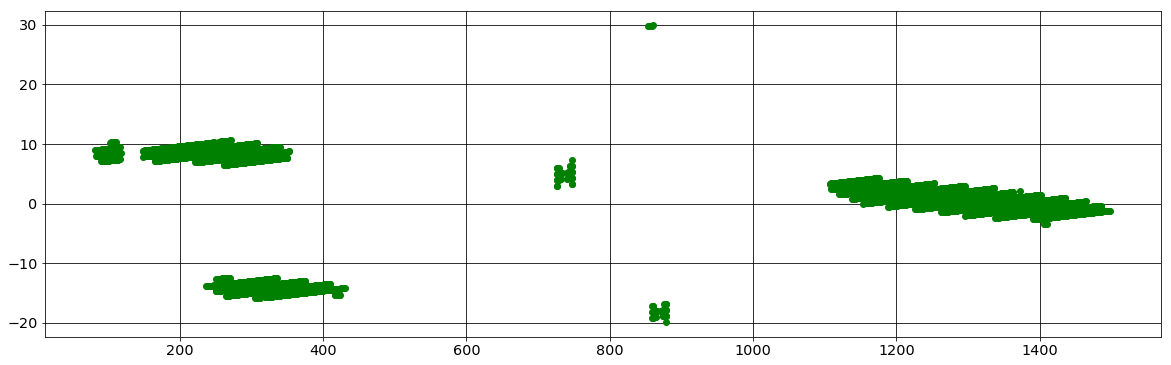

In [51]:
xtofit=[]
ytofit=[]
for iy,y in enumerate(theta_mask):
    for ix,x in enumerate(y):
        if not np.isnan(theta_mask[iy][ix]) :
            if np.abs(theta_mask[iy][ix])>deg_threshold : continue
            xtofit.append(ix)
            ytofit.append(iy)
popt, pcov = fit_line(xtofit, ytofit)
[a, b] = popt
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = line(x_new,a,b)
print 'Rotation angle from fit :',np.arctan(a)*180/np.pi
fig = plt.figure(figsize=[20,6])
plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-deg_threshold,vmax=deg_threshold)
plt.plot(x_new,y_new,'b-')
plt.grid(color='black', ls='solid')
plt.show()
fig = plt.figure(figsize=[20,6])
diff = []
for ix,x in enumerate(xtofit):
    diff.append(ytofit[ix]-line(x,a,b))
plt.plot(xtofit,diff,'go')
plt.grid(color='black', ls='solid')
plt.show()

Je pense que la méthode de de l'histogramme est plus adaptée à la recherche de spectres continus

Using Hessian theta angles:
0  theta =  -1.57550305852
1  theta =  -1.17217317276
2  theta =  -0.571294118627
3  theta =  -0.830141004271


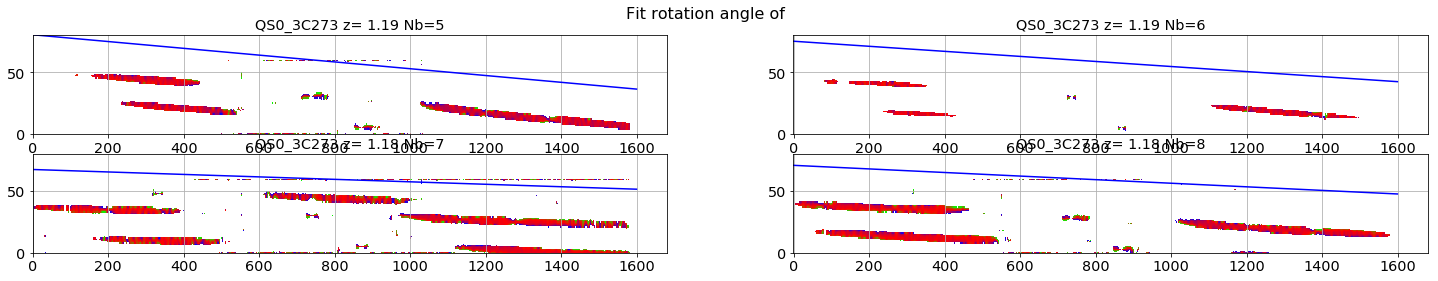

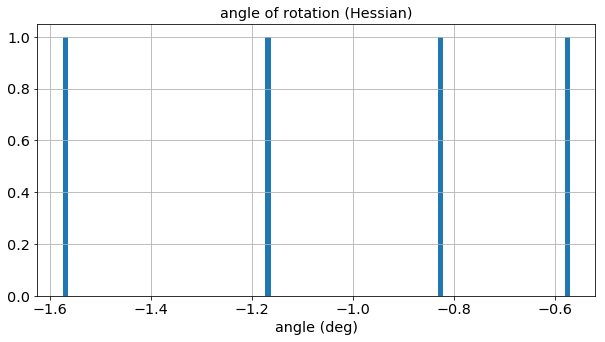

In [62]:
print 'Using Hessian theta angles:'

all_theta=ComputeRotationAngleHessian(all_images,x_guess,DeltaY,all_titles,object_name, 
    NBIMGPERROW=2, lambda_threshold = -2, deg_threshold = 10, width_cut = 40, right_edge = 1600, margin_cut = 10)
figfilename=os.path.join(dir_top_images,'fit_rotation.pdf')
plt.savefig(figfilename)  

for index in range(len(all_theta)):
    print index,' theta = ',all_theta[index]
plt.figure(figsize=(10,5))
n, bins, patches=plt.hist(all_theta,bins=100,histtype='stepfilled')
plt.grid(True)
plt.title('angle of rotation (Hessian)')
plt.xlabel('angle (deg)')

### Turn the images accordingly

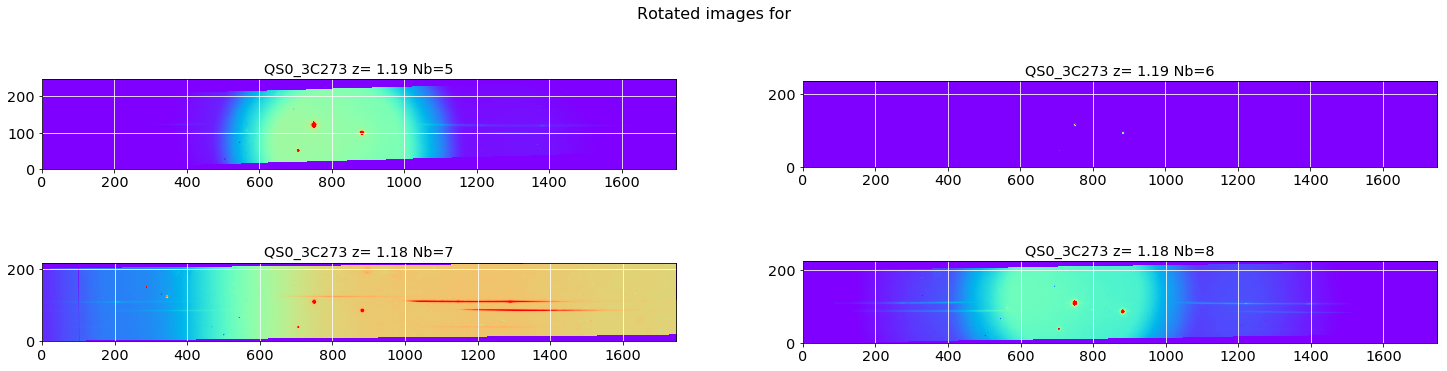

In [57]:
turned_images=TurnTheImages(all_images,all_theta,all_titles,object_name,
                            NBIMGPERROW=2,vmin=500,vmax=10000,oversample_factor=1)
figfilename=os.path.join(dir_top_images,'rotated_images.pdf')
plt.savefig(figfilename)  

### Check rotation

In case of bad rotation, check by eye

array([-0.16762229, -0.09571181, -0.07553109, -0.12082065])

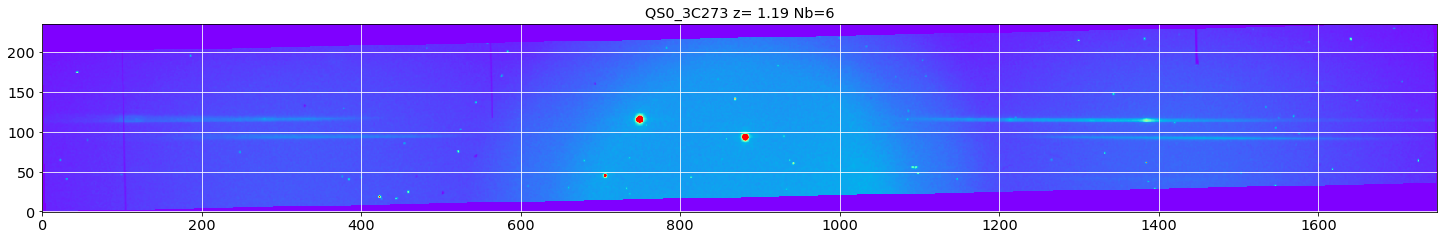

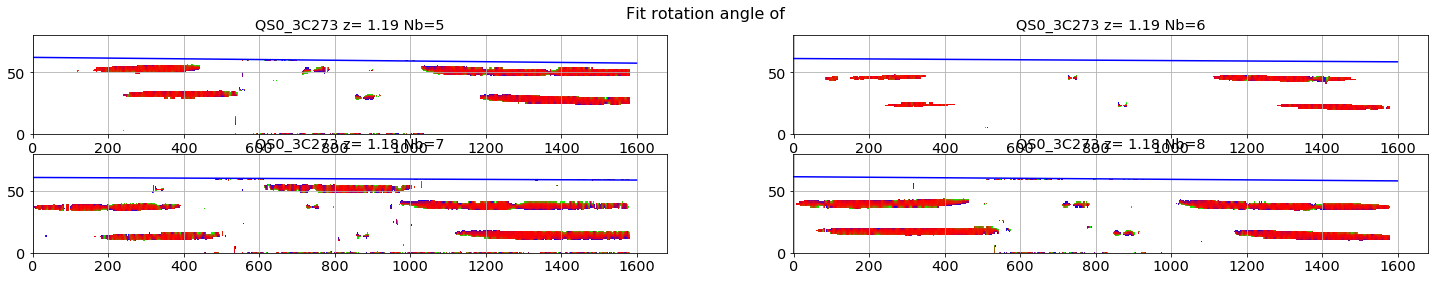

In [60]:
sel=1
plt.figure(figsize=(25,10))
plt.imshow(turned_images[sel],origin='lower',cmap='rainbow',vmin=0,vmax=1000)
plt.grid(True)
plt.title(all_titles[sel])
plt.grid(color='white', ls='solid')
figfilename=os.path.join(dir_top_images,'rotated_image_sample.pdf')
plt.savefig(figfilename)  

ComputeRotationAngleHessian(turned_images,x_guess,DeltaY,all_titles,object_name,
    NBIMGPERROW=2, lambda_threshold = -2, deg_threshold = 10, width_cut = 40, right_edge = 1600, margin_cut = 10)

Cut the extra spectra that pollute the images.

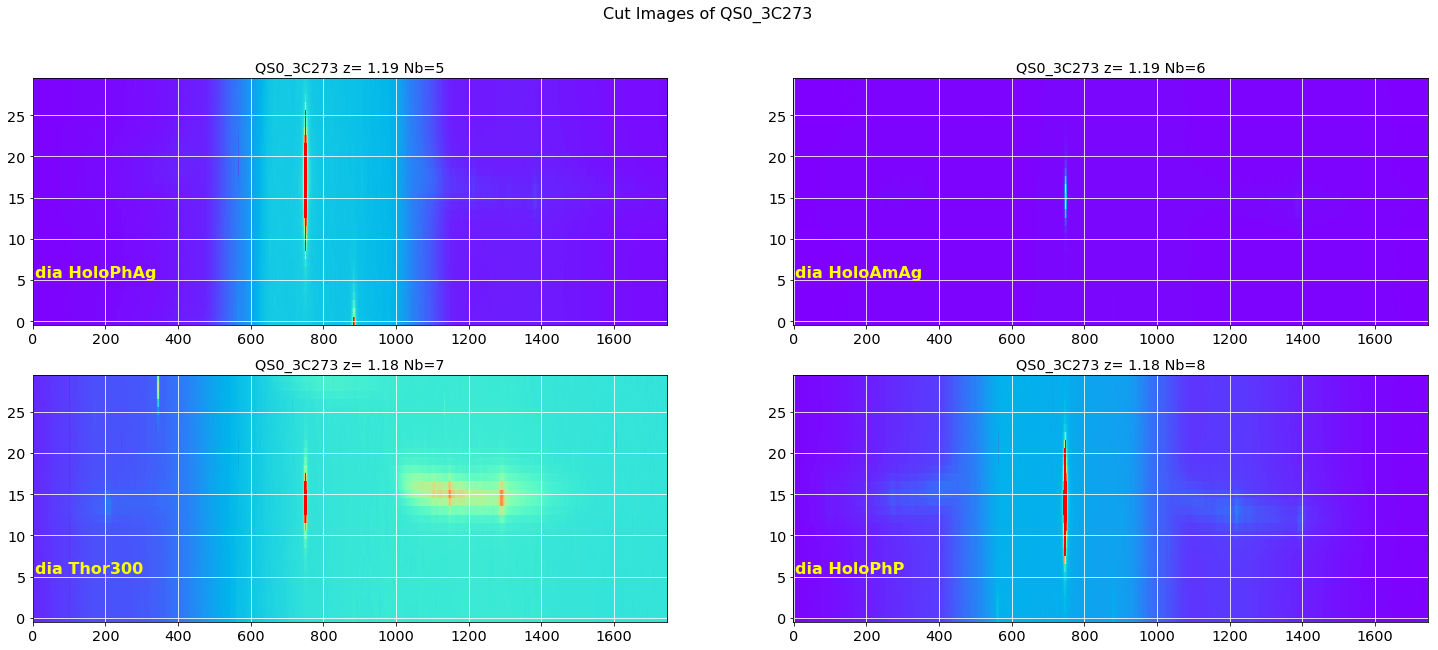

In [64]:
DeltaY_rot2 = [15]*len(all_images)
y_guess_rot2 = [119,115,108,110]
images_cut_rot=ShowCenterImages(x_guess,y_guess_rot2,DeltaX,DeltaY_rot2,
                    turned_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=20000) 

# Find the central star locations
======================================

### Central star positions after rotation and cut

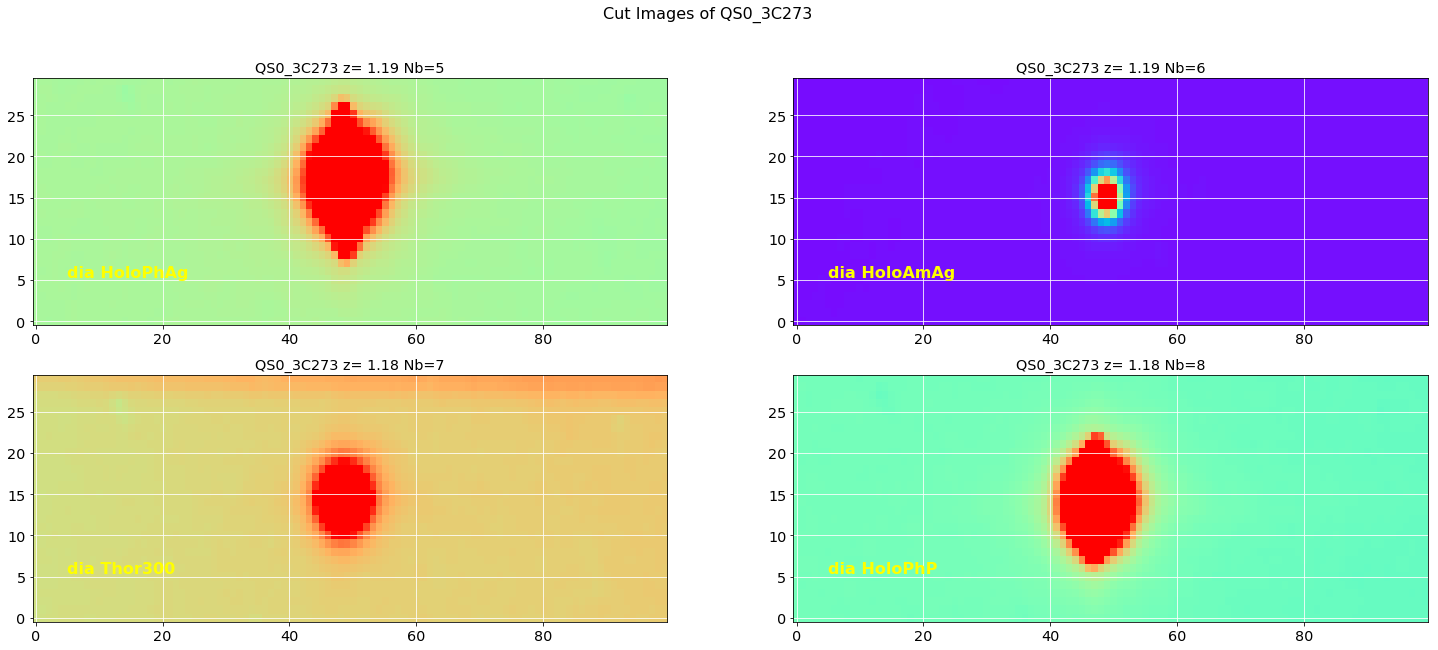

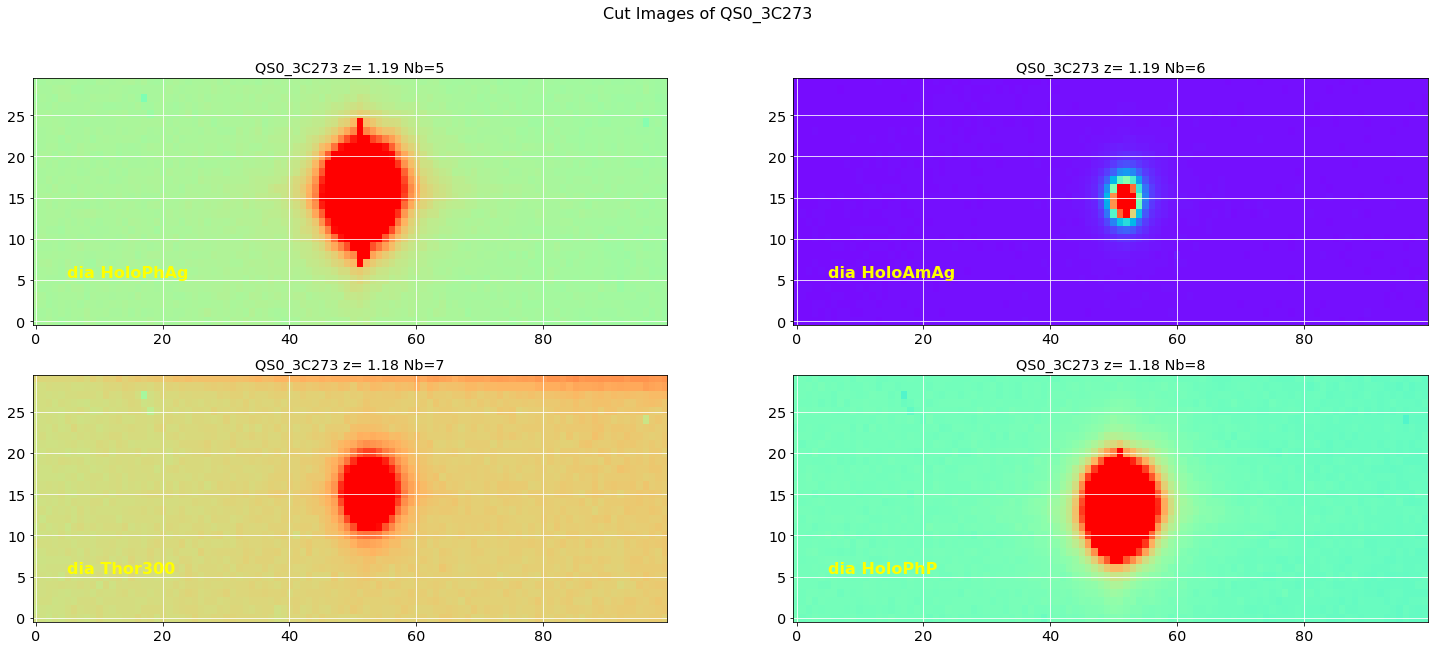

In [66]:
x_guess_rot = [750]*len(all_images)
y_guess_rot = DeltaY_rot2
DeltaY_rot = [15]*len(all_images)
DeltaX_rot = [50]*len(all_images)

images_cut=ShowCenterImages(x_guess_rot,y_guess_rot,DeltaX_rot,DeltaY_rot,
                    images_cut_rot,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=10000) 
images_cut_before_rot=ShowCenterImages(x_guess,[100]*len(all_images),DeltaX_rot,DeltaY_rot,
                    all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=10000) 

In [67]:
# (JN) valeurs optimisées pour cette étude
img_mean,img_median,img_std,img_sources=ComputeStatImages(images_cut,fwhm=8,threshold=2,sigma=10.0,iters=5)

----------------------------------------------------------------
0  mean, median, std =  7362.02055186 5859.4961538 7345.42179015
 id   xcentroid     ycentroid   ...      peak          flux          mag     
--- ------------- ------------- ... ------------- ------------- -------------
  1 48.5994092411 17.0924274955 ... 54740.1237766 7.72061334369 -2.2191295077
----------------------------------------------------------------
1  mean, median, std =  222.747433031 210.386785916 76.3020516985
 id   xcentroid     ycentroid   ...      peak          flux          mag     
--- ------------- ------------- ... ------------- ------------- -------------
  1 48.8313131679 15.0953567907 ... 18287.9050279 214.638907275 -5.8292711217
----------------------------------------------------------------
2  mean, median, std =  7018.46748359 6973.5336279 448.179665295
 id   xcentroid     ycentroid   ...     peak         flux          mag      
--- ------------- ------------- ... ------------ ------------ --

        Use DAOStarFinder instead. [common_notebook]


### Central star position

[[ 748.59940924   17.0924275 ]
 [ 748.83131317   15.09535679]
 [ 748.36347877   14.15453506]
 [ 747.27226758   13.78877349]]


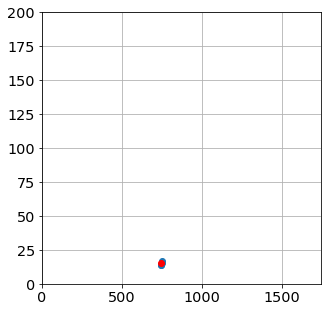

In [68]:
x_star = []
y_star = []
for index,s in enumerate(img_sources):
    for ss in s:
        x_star.append(ss['xcentroid']+x_guess_rot[index]-DeltaX_rot[index])
        y_star.append(ss['ycentroid']+y_guess_rot[index]-DeltaY_rot[index])
        
positions_central = np.array([x_star,y_star]).T
print positions_central

x_mean = np.mean(x_star)
y_mean = np.mean(y_star)
img_size=all_images[0].shape
plt.figure(figsize=(5,5))
plt.plot(x_star,y_star,'o')
plt.plot(x_mean,y_mean,'ro')
plt.xlim(0,img_size[1])
plt.ylim(0,img_size[0])
plt.grid(True)

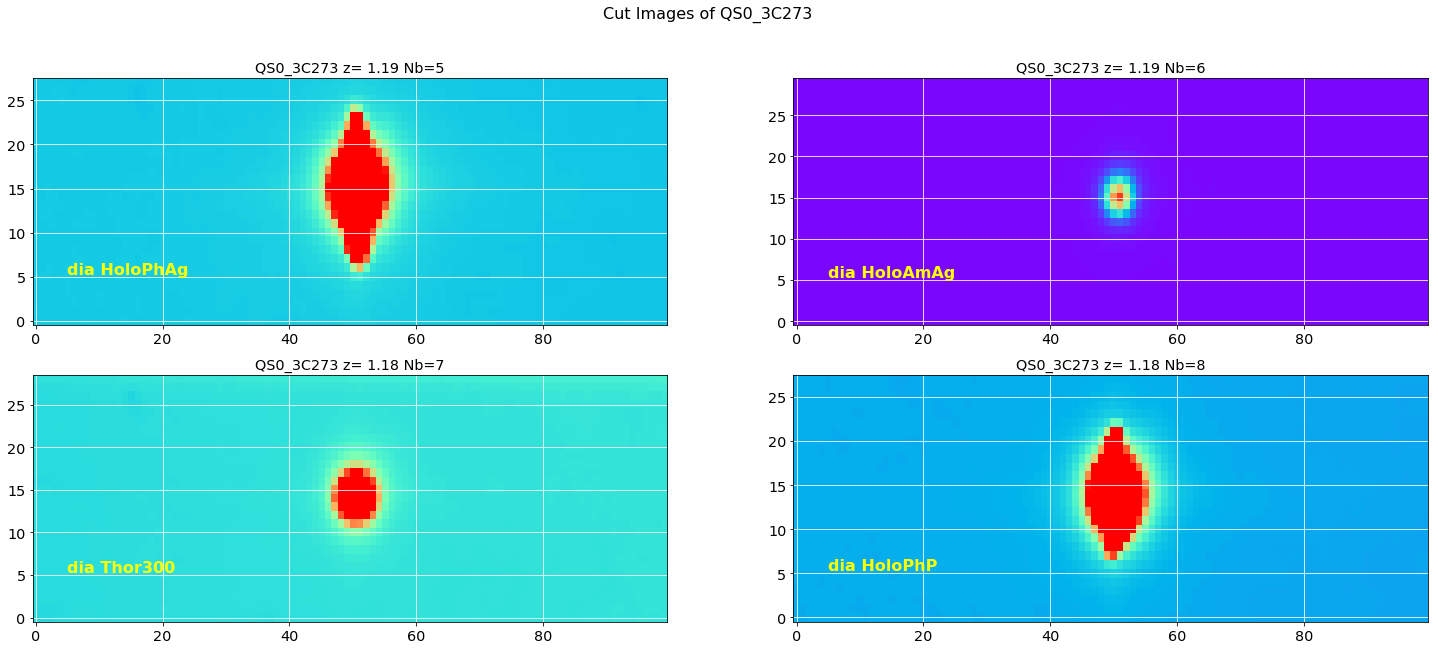

In [70]:
tmp = ShowCenterImages(x_star,y_star,DeltaX_rot,DeltaY_rot,
                    images_cut_rot,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=20000) 

## Save results

Save the cut images after rotation.

In [71]:
newfullfilenames=[]
for idx,f in np.ndenumerate(sorted_files):
    short_infilename=f.split("/")[2]
    short_partfilename=re.findall('^cutimg_(.*)',short_infilename)
    short_outfilename='rotimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [72]:
for idx,f in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut_rot[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(f,overwrite=True)
textfilename=os.path.join(outputdir,'star_centroids.txt')
print textfilename
np.savetxt(textfilename,positions_central,header="y_star x_star",fmt='%d')

!ls -l rotated_fitsimages

./rotated_fitsimages/star_centroids.txt
total 3400
-rw-r--r--  1 jneveu  staff  432000  8 aoû 14:59 rotimg_20170605_005.fits
-rw-r--r--  1 jneveu  staff  432000  8 aoû 14:59 rotimg_20170605_006.fits
-rw-r--r--  1 jneveu  staff  432000  8 aoû 14:59 rotimg_20170605_007.fits
-rw-r--r--  1 jneveu  staff  432000  8 aoû 14:59 rotimg_20170605_008.fits
-rw-r--r--  1 jneveu  staff      44  8 aoû 14:59 star_centroids.txt


# Extract spectra
===================================

In [73]:
outputdir="./spectrum_fitsspec"
ensure_dir(outputdir)

inputdir="./rotated_fitsimages"
SelectTagRe='^rotimg_%s_([0-9]+).fits$' % date # regular expression to select the file
SearchTagRe='^rotimg_%s_[0-9]+.fits$' % date

In [74]:
sorted_numbers,sorted_files = MakeFileList([inputdir],MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe) 

all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

print 'Number of images:',len(all_images)

Number of images: 4


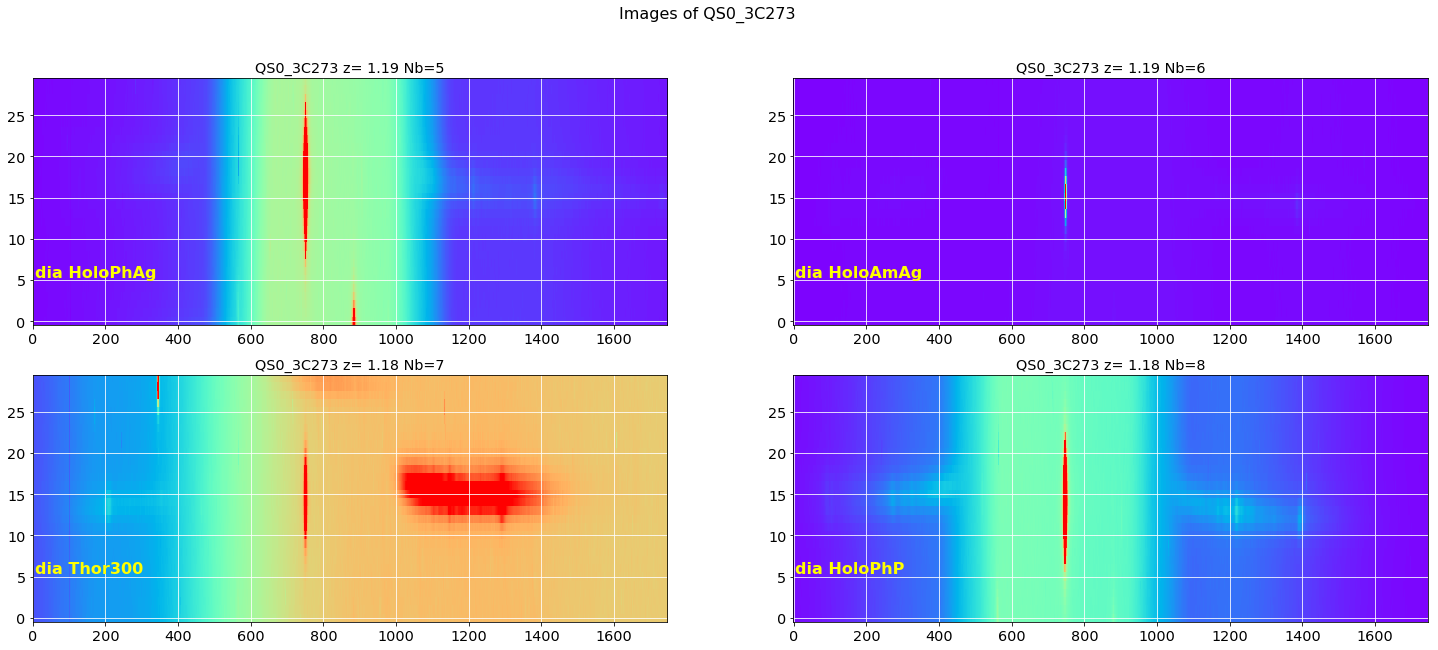

In [76]:
ShowImages(all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=10000)

[17.092427495482241, 15.095356790694133, 14.15453505969241, 13.78877348882521]


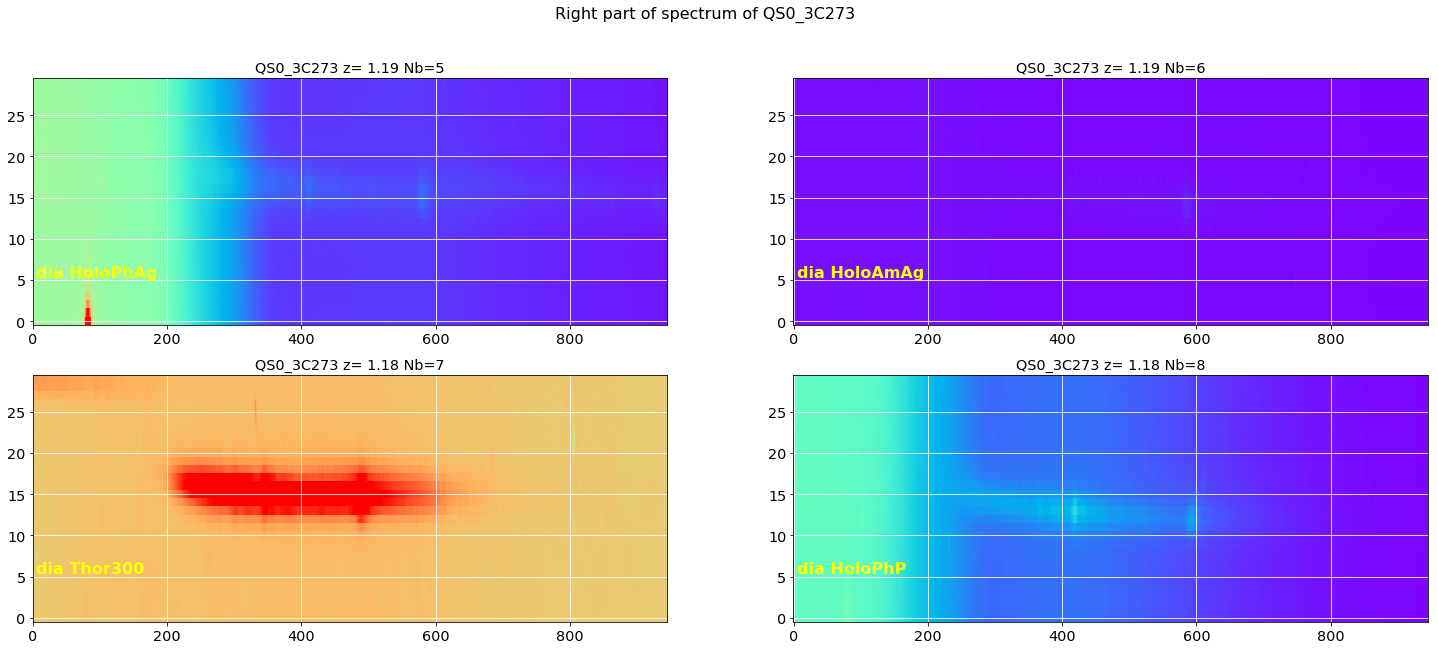

In [81]:
# Right spectrum
print y_star
ShowCenterImages([1300]*len(all_images),y_star,[500]*len(all_images),[30]*len(all_images),
                 all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=10000)
title='Right part of spectrum of {} '.format(object_name)
plt.suptitle(title,size=16)
figfilename=os.path.join(dir_top_images,'rightorder.pdf')
plt.savefig(figfilename)  

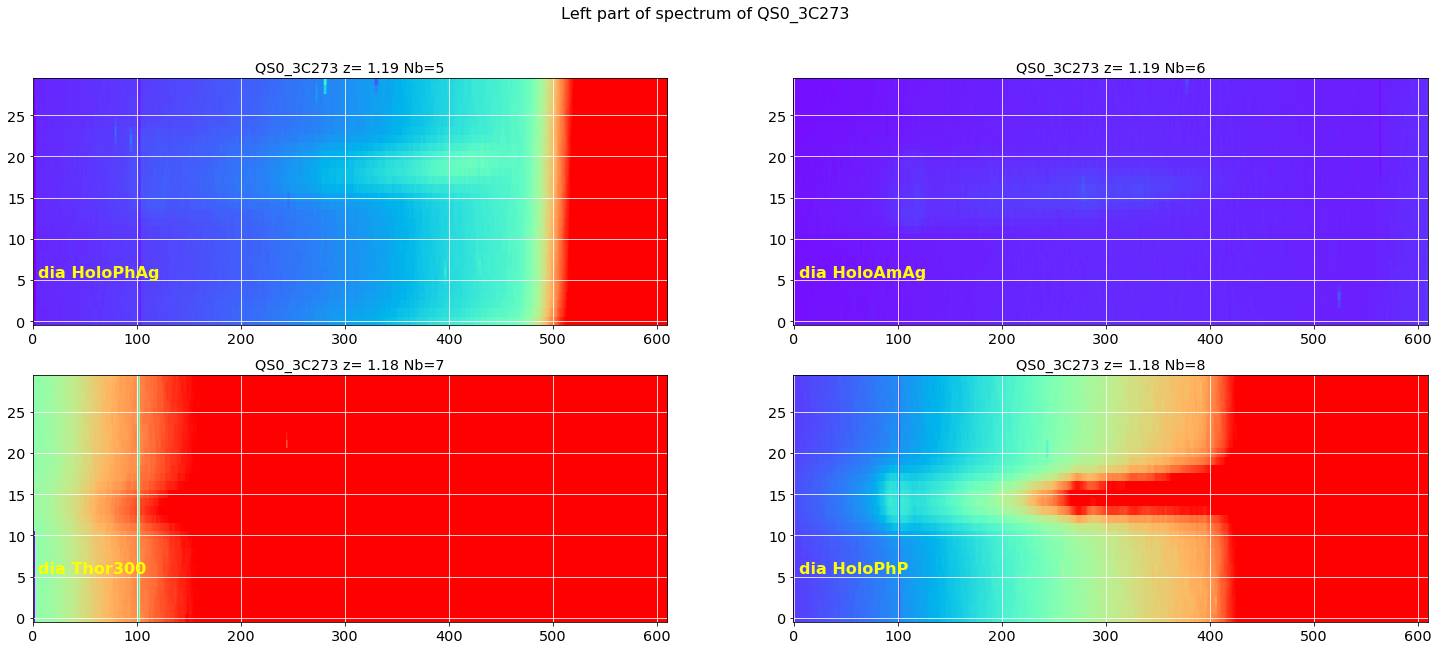

In [82]:
# Left spectrum
ShowCenterImages([110]*len(all_images),y_star,[500]*len(all_images),[30]*len(all_images),
                 all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=2000)
title='Left part of spectrum of {} '.format(object_name)
plt.suptitle(title,size=16)
figfilename=os.path.join(dir_top_images,'leftorder.pdf')
plt.savefig(figfilename)  

### Extraction

[16, 15, 15, 14]

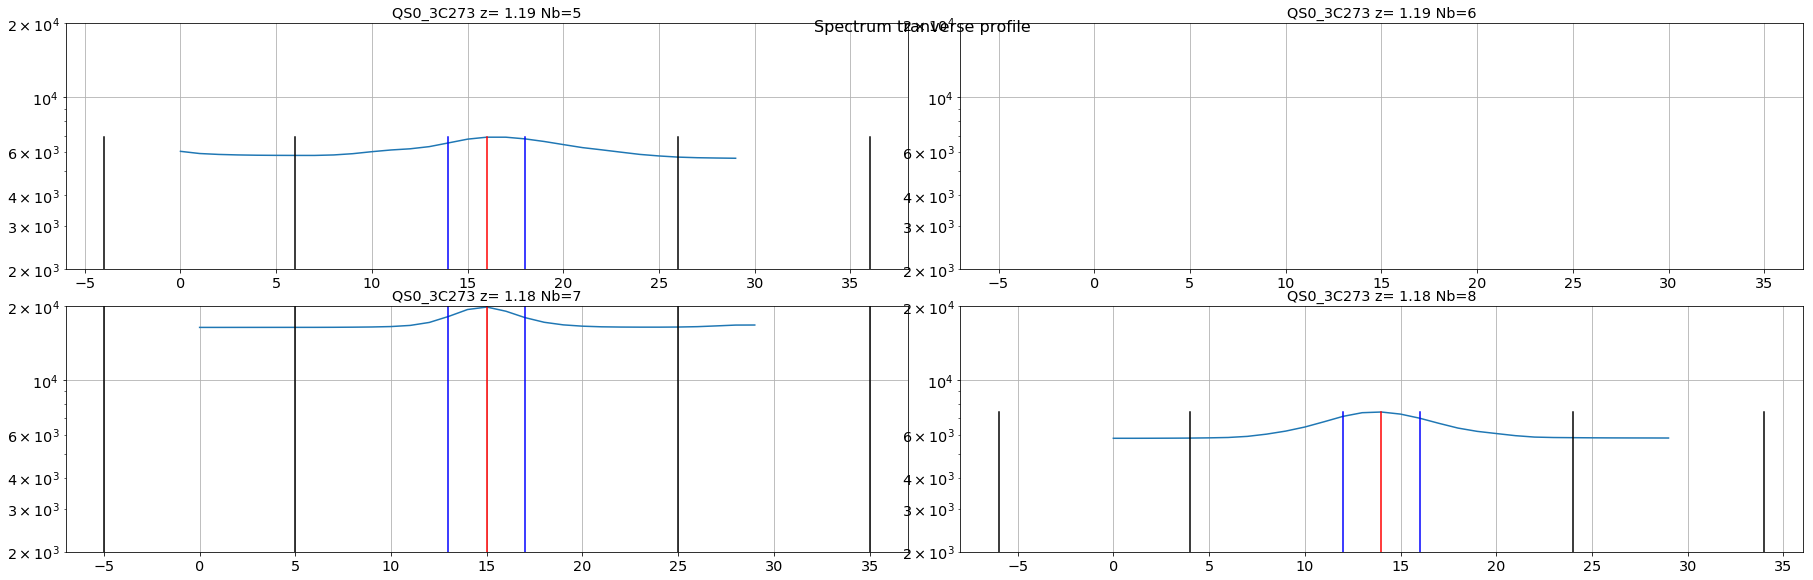

In [141]:
ShowTransverseProfile(all_images,all_titles,object_name,all_expo,NBIMGPERROW=2,
                      DeltaX=1000,w=2,ws=[10,20],right_edge=1800,ylim=(2e3,2e4))

In [169]:
thespectra,thespectraUp,thespectraDown=ExtractSpectra(y_star,all_images,all_titles,object_name,all_expo,
                                                      w=3,ws=[8,30],right_edge=1800)

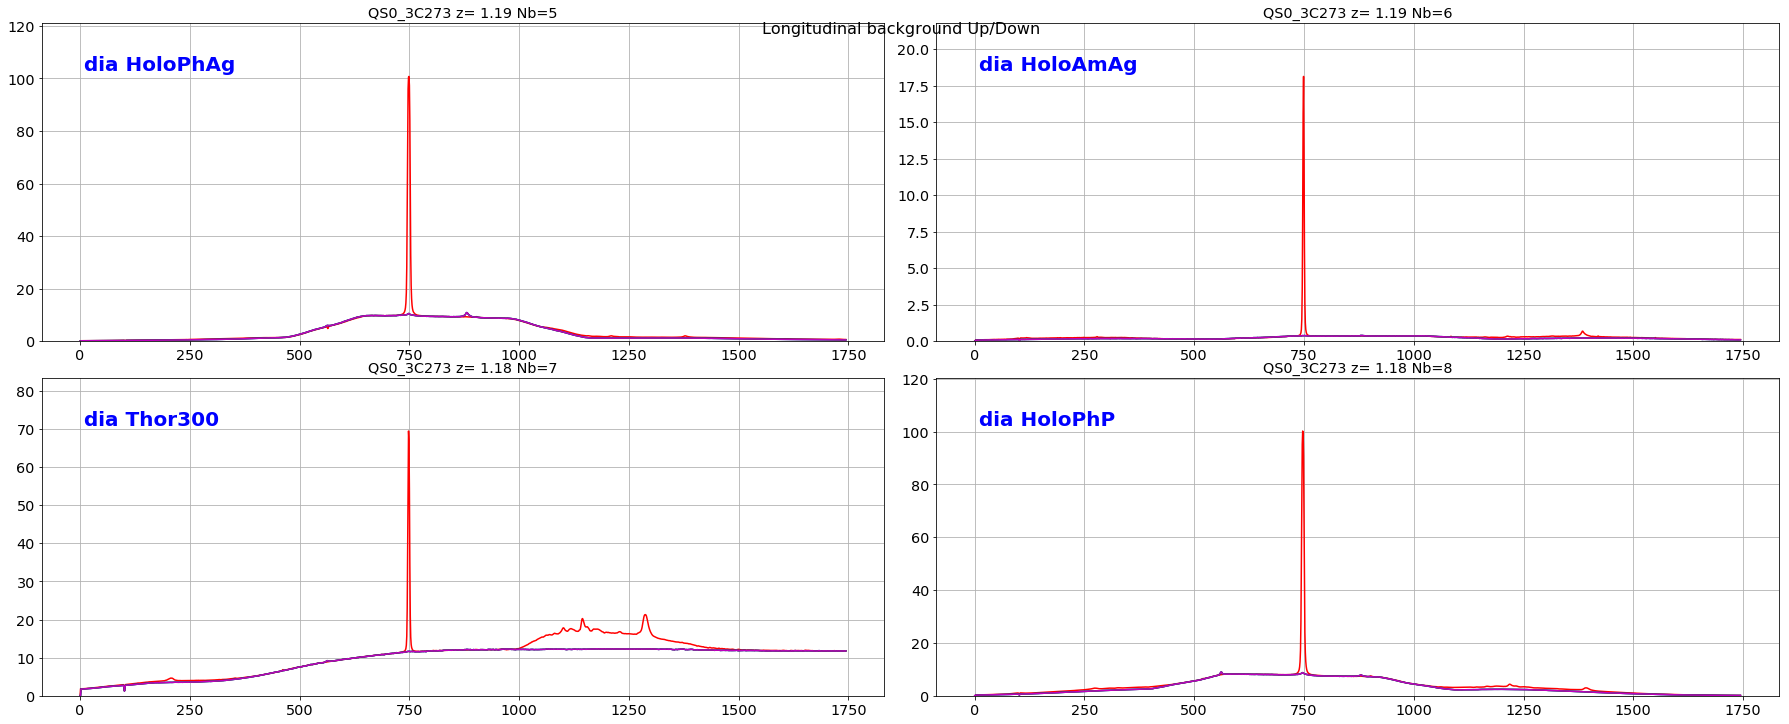

In [170]:
Clean_Up, Clean_Do,Clean_Av=CleanBadPixels(thespectraUp,thespectraDown) 

ShowLongitBackground(thespectra,Clean_Up,Clean_Do,Clean_Av,all_titles,all_filt,object_name,
                     NBIMGPERROW=2,right_edge=1800)
figfilename=os.path.join(dir_top_images,'background_longprofile.pdf')
plt.savefig(figfilename)   

(0, 20.0)

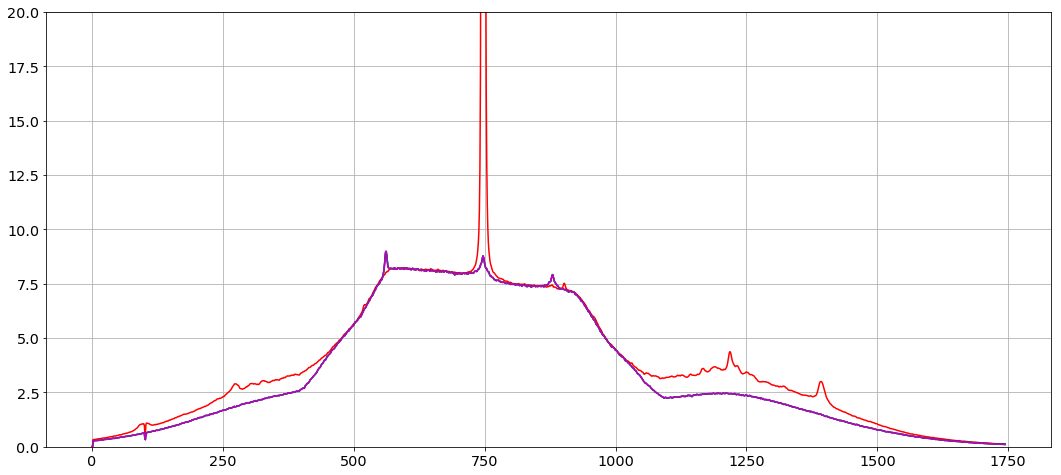

In [171]:
sel=3
plt.figure(figsize=(18,8))
plt.plot(thespectra[sel],'r-') 
plt.plot(Clean_Up[sel],'b-') 
plt.plot(Clean_Do[sel],'g-')
plt.plot(Clean_Av[sel],'m-')
plt.grid(True)
plt.ylim(0,20.)

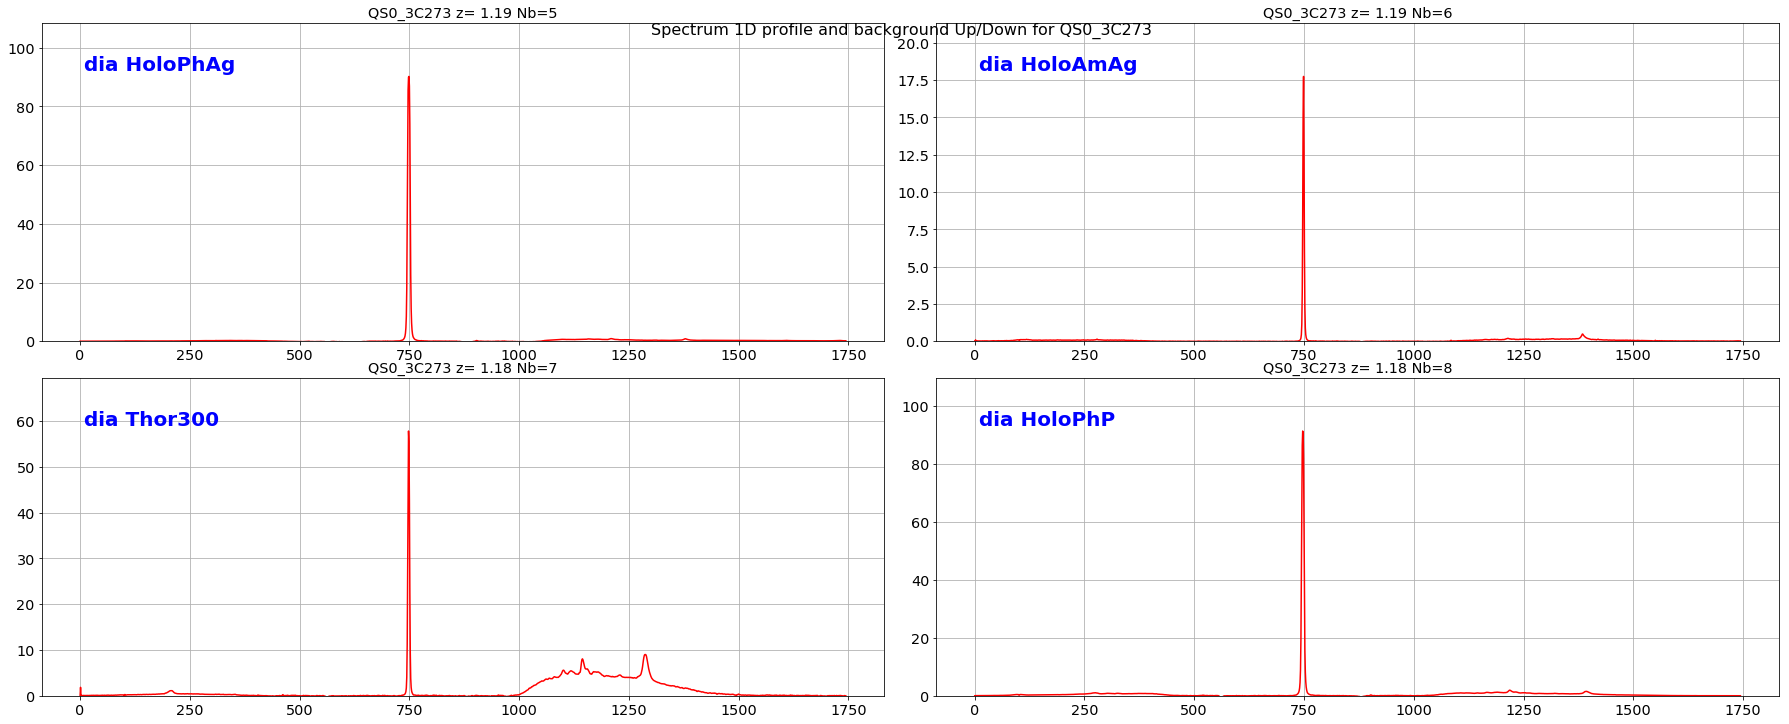

In [172]:
thecorrspectra=CorrectSpectrumFromBackground(thespectra,Clean_Av)

ShowSpectrumProfile(thecorrspectra,all_titles,object_name,all_filt,NBIMGPERROW=2)
figfilename=os.path.join(dir_top_images,'correctedspectrum_profile.pdf')
plt.savefig(figfilename) 

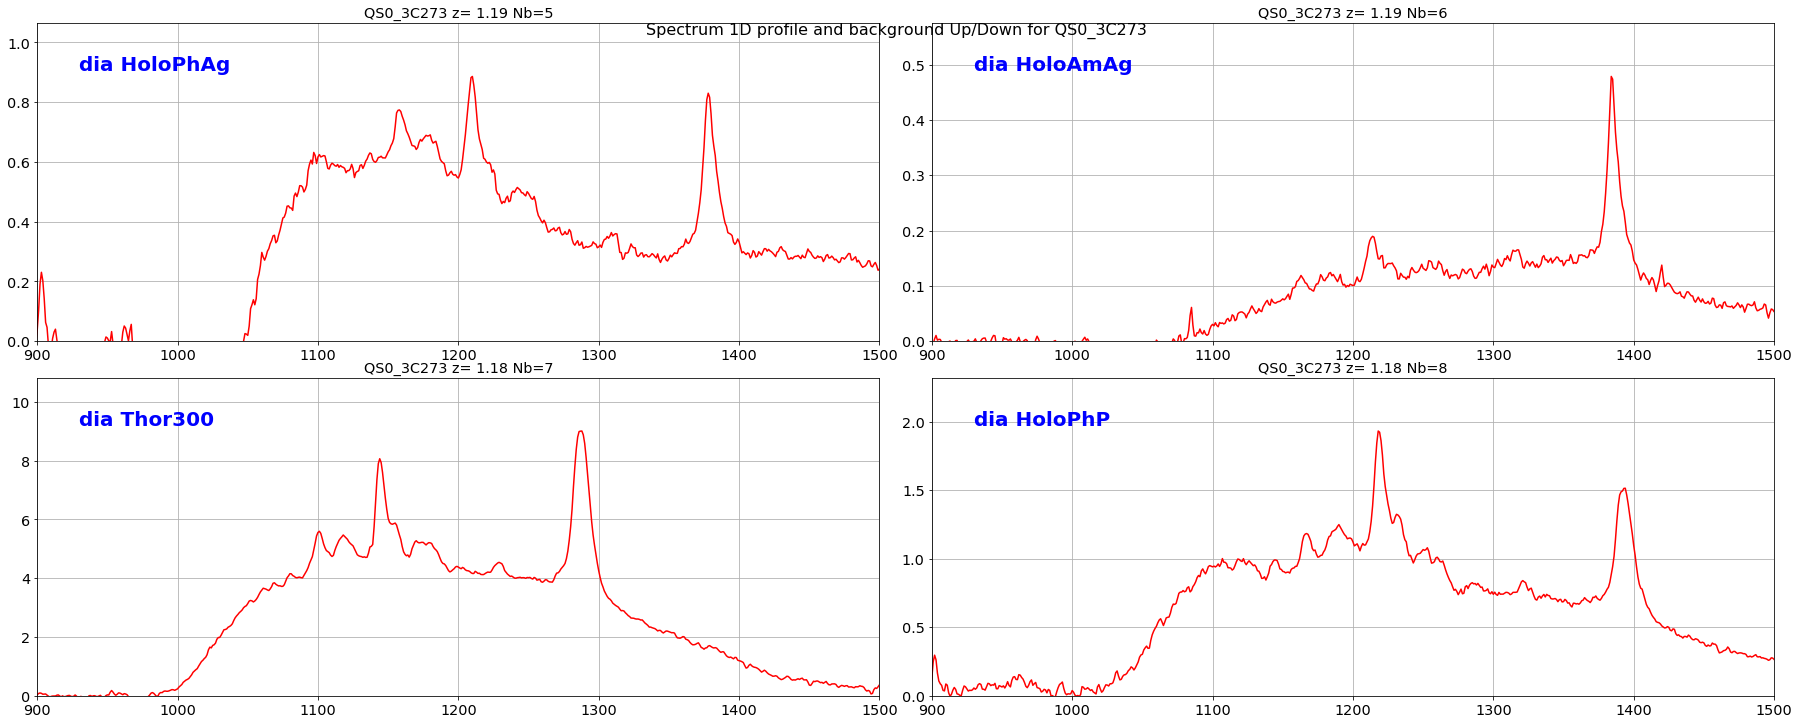

In [173]:
ShowSpectrumProfile(thecorrspectra,all_titles,object_name,all_filt,NBIMGPERROW=2,xlim=(900,1500))
figfilename=os.path.join(dir_top_images,'correctedspectrum_rightprofile.pdf')
plt.savefig(figfilename) 

# Emission line identification

In [174]:
all_grat = []
for f in all_filt :
    all_grat.append(f.replace('dia ',''))

MAIN_ID       RA           DEC      RA_PREC ... SP_TYPE_4 SP_QUAL_4 SP_BIBCODE_4
           "h:m:s"       "d:m:s"            ...                                 
------- ------------- ------------- ------- ... --------- --------- ------------
 3C 273 12 29 06.6951 +02 03 08.662       9 ...                                 
HoloPhAg
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -2.1 degrees
N = 349.60 +/- 1.13 grooves/mm
Hologram center at x0 = 1105.0 and y0 = 599.0 with average tilt of -2.1 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -2.1 degrees
Order  0 position at x0 = 840.1 and y0 = 608.9
Order +1 position at x0 = 1369.9 and y0 = 589.1
Distance between the orders: 530.15 pixels (12.72 mm)
-----------------------------------------------------
HoloAmAg
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -1.4 degrees
N = 351.85 +/- 1.14 grooves/mm
Hologram center at x0 = 1085.0 and y0 = 648.0 with average tilt o

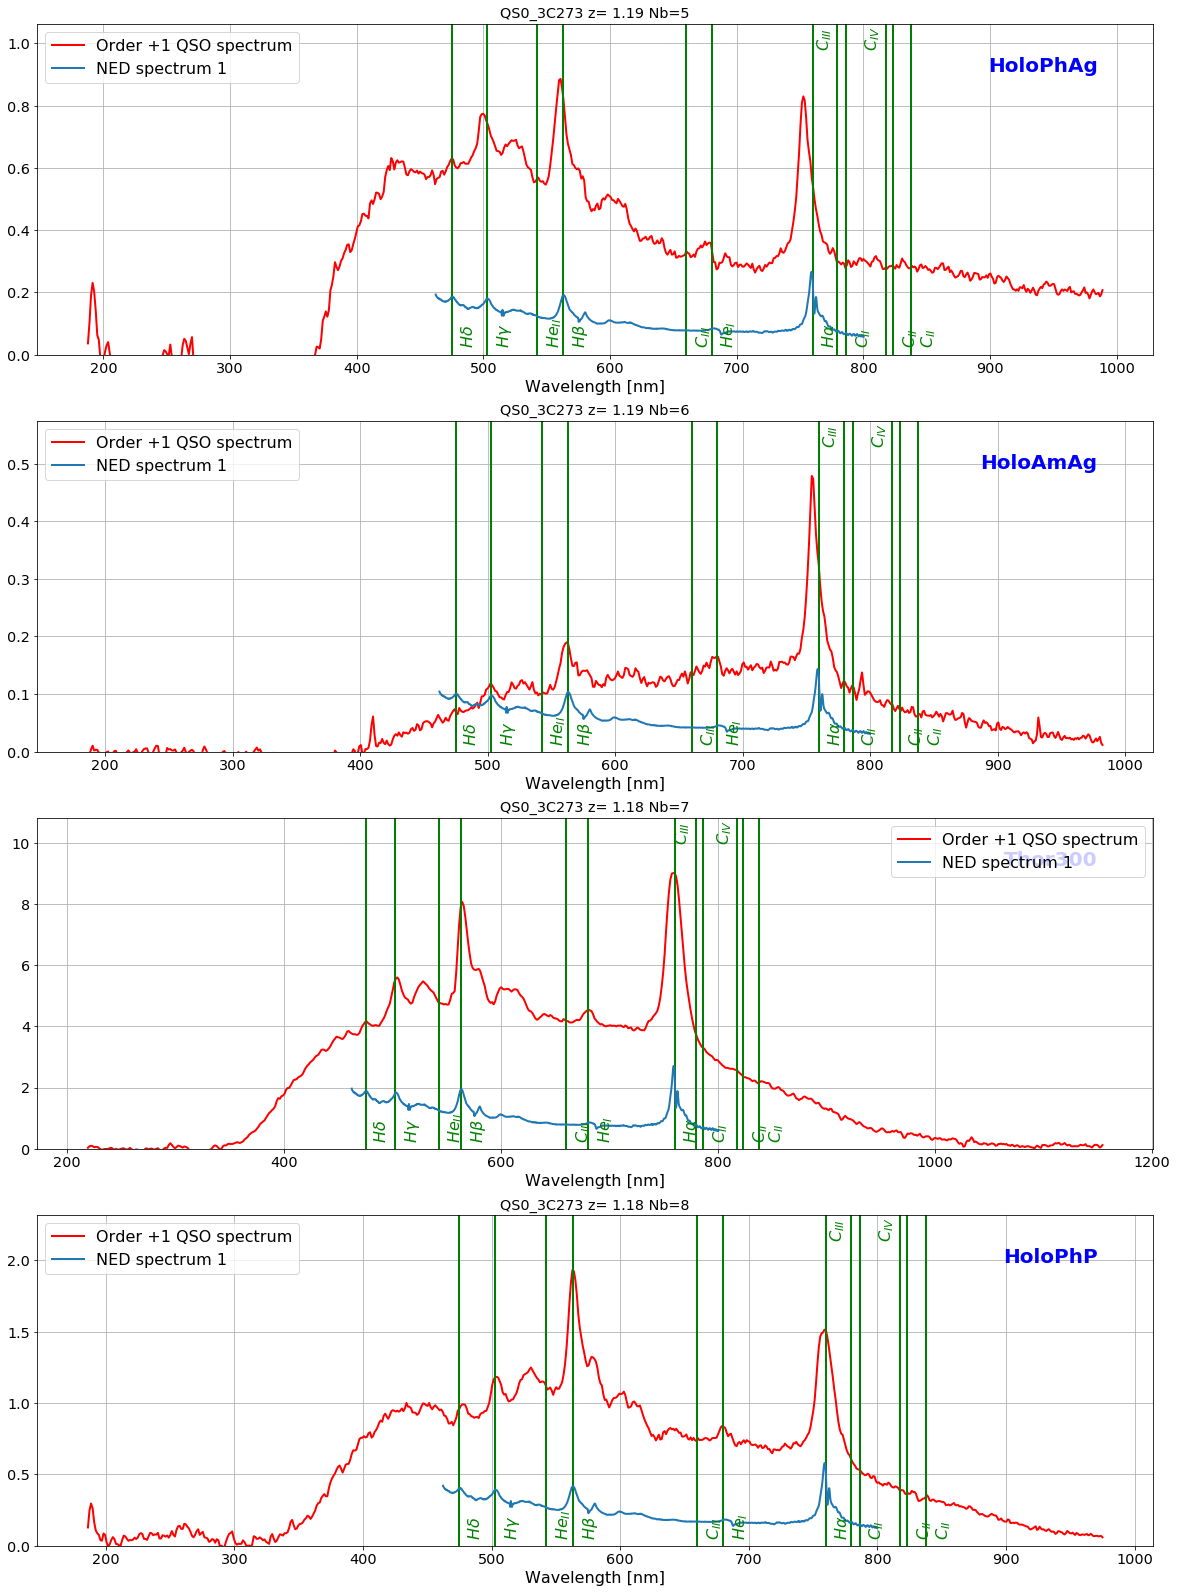

In [175]:
QSO_3C273_REDSHIFT = 0.158

QSO = Target("3C273")

CalibrateSpectra(thecorrspectra,QSO_3C273_REDSHIFT,x_star,all_titles,object_name,all_grat,xlim=(900,1600),target=QSO)
figfilename=os.path.join(dir_top_images,'calibrated_spectrum_profile.pdf')
plt.savefig(figfilename)  

## Save results

In [ ]:
newfullfilenames=[]
for idx,f in np.ndenumerate(sorted_files):
    short_infilename=f.split("/")[-1]
    short_partfilename=re.findall('^rotimg_(.*)',short_infilename)
    short_outfilename='finalSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)
    
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=thecorrspectra[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,clobber=True)
    
%ls -l spectrum_fitsspec